First three code chunk are pip installation steps, that are required to import the package, so, if your system doesn't already have Keras,TensorFlow and OpenCV, you need to download and install them using pip command mentioned below.

In [ ]:
#download and install the package keras 
pip install keras

#Run this code block only to install keras (if not already installed in system)

In [ ]:
#download and install the package tensorflow 
pip install tensorflow

#Run this code block only to install keras (if not already installed in system)

In [ ]:
#download and install the package openCV 
pip install opencv-python

#Run this code block only to install keras (if not already installed in system)

In [1]:
#import packages
import numpy as np
import keras
import keras.backend as k
from keras.layers import Conv2D,MaxPooling2D,SpatialDropout2D,Flatten,Dropout,Dense
from keras.models import Sequential,load_model
from keras.optimizers import Adam
from keras.preprocessing import image
import cv2
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
model=Sequential() #define keras model
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3))) #define convulation neural network
model.add(MaxPooling2D() )
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
#generate an image
from keras.preprocessing.image import ImageDataGenerator
train_data_generator = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_data_generator = ImageDataGenerator(rescale=1./255)

data_train = train_data_generator.flow_from_directory(
        '--PATH/project-dakshkhanna/dataset/train/', #add path for your saved directory
        target_size=(150,150),
        batch_size=16 ,
        class_mode='binary')

data_test = test_data_generator.flow_from_directory(
        '--PATH/project-dakshkhanna/dataset/test/', #add path for your saved directory
        target_size=(150,150),
        batch_size=16,
        class_mode='binary')
#save the best fit model
model_saved=model.fit_generator(
        data_train,
        epochs=10,
        validation_data=data_test,

        )

model.save('mymodel.h5',model_saved)

Found 1314 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


<ipython-input-3-31dbe4c337ee>:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_saved=model.fit_generator(


Epoch 1/10
83/83 [==============================] - 33s 387ms/step - loss: 0.3915 - accuracy: 0.8052 - val_loss: 0.1372 - val_accuracy: 0.9433
Epoch 2/10
83/83 [==============================] - 31s 366ms/step - loss: 0.1845 - accuracy: 0.9376 - val_loss: 0.1254 - val_accuracy: 0.9536
Epoch 3/10
83/83 [==============================] - 30s 361ms/step - loss: 0.1089 - accuracy: 0.9650 - val_loss: 0.0932 - val_accuracy: 0.9588
Epoch 4/10
83/83 [==============================] - 32s 384ms/step - loss: 0.1086 - accuracy: 0.9612 - val_loss: 0.0874 - val_accuracy: 0.9639
Epoch 5/10
83/83 [==============================] - 32s 391ms/step - loss: 0.1198 - accuracy: 0.9597 - val_loss: 0.1455 - val_accuracy: 0.9485
Epoch 6/10
83/83 [==============================] - 33s 401ms/step - loss: 0.0962 - accuracy: 0.9612 - val_loss: 0.0998 - val_accuracy: 0.9742
Epoch 7/10
83/83 [==============================] - 30s 357ms/step - loss: 0.0799 - accuracy: 0.9718 - val_loss: 0.1013 - val_accuracy: 0.9536

In [4]:
#check for the value loss while prediction
loss_val = model_saved.history['val_loss']
loss_val

[0.1371505707502365,
 0.12536415457725525,
 0.09316208213567734,
 0.08741317689418793,
 0.14551882445812225,
 0.09983863681554794,
 0.1013336256146431,
 0.06406299769878387,
 0.05832018703222275,
 0.07693241536617279]

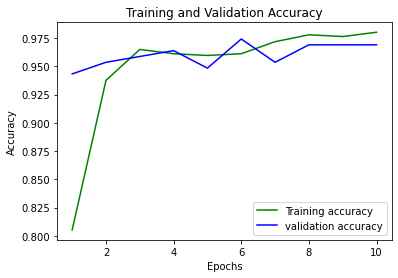

In [6]:
#Create an Epoch-Accuracy plot

acc_train = model_saved.history['accuracy']
acc_val = model_saved.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
#load the best selected model ~ mymodel.h5
mymodel=load_model('mymodel.h5')
#Add the path to your saved directory
#test_image=tf.keras.utils.load_img(r'/Users/dakshkhanna/Desktop/project-dakshkhanna/dataset/test/with_mask/1-with-mask.jpg',
test_image=tf.keras.utils.load_img(r'--PATH /project-dakshkhanna/dataset/test/with_mask/1-with-mask.jpg',
                          target_size=(150,150,3))
test_image
test_image=tf.keras.preprocessing.image.img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
mymodel.predict(test_image)[0][0]

# IMPLEMENTING LIVE DETECTION OF FACE MASK

model_det=load_model('mymodel.h5')

cap=cv2.VideoCapture(0)
#face_cascade=cv2.CascadeClassifier('/Users/dakshkhanna/Desktop/project-dakshkhanna/haarcascade_frontalface_default.xml')
face_cascade=cv2.CascadeClassifier('--PATH/project-dakshkhanna/haarcascade_frontalface_default.xml') #Add path for your saved directory

while cap.isOpened():
    _,img=cap.read()
    face=face_cascade.detectMultiScale(img,scaleFactor=1.1,minNeighbors=4)
    for(x,y,w,h) in face:
        face_img = img[y:y+h, x:x+w]
        cv2.imwrite('temp.jpg',face_img)
        test_image=tf.keras.utils.load_img('temp.jpg',target_size=(150,150,3))
        test_image=tf.keras.preprocessing.image.img_to_array(test_image)
        test_image=np.expand_dims(test_image,axis=0)
        pred=model_det.predict(test_image)[0][0]
        if pred==1:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),3)
            cv2.putText(img,'Not Wearing Mask',((x+w)//2,y+h+20),cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,1,(0,0,255),3)
        else:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)
            cv2.putText(img,'Wearing Mask',((x+w)//2,y+h+20),cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,1,(0,255,0),3)
        datet=str(datetime.datetime.now())
        cv2.putText(img,datet,(400,450),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),1)
          
    cv2.imshow('img',img)
    
    if cv2.waitKey(1)==ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 22ms/step


KeyboardInterrupt: 